# Casino Player Segmentation

## Installing packages

In [ ]:
!pip install --upgrade pip
!pip install "snowflake-connector-python[pandas]" "snowflake-snowpark-python[pandas]" snowflake-snowpark-python==1.9.0 numpy pandas matplotlib scikit-learn xgboost seaborn python-dateutil tqdm holidays faker
!pip install --upgrade --q snowflake-snowpark-python==1.9.0
!pip uninstall urllib3 -y
!pip install urllib3==1.26.15
!pip install fosforml==1.1.6

In [45]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
!pip install yellowbrick

### Importing packages

In [1]:
from fosforml import *
from fosforml.constants import MLModelFlavours
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
import warnings; warnings.simplefilter('ignore')
from joblib import dump, load
import requests
from tqdm import tqdm
import time
import calendar

from time import sleep
import configparser
from dateutil.relativedelta import relativedelta
import datetime
from dateutil.easter import easter
from scipy.optimize import minimize_scalar
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
#Importing the Libraries

import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

## Data Pull and Push

### Getting data from Github and moving to SF

In [ ]:
# URL of the CSV file on GitHub
#url = 'https://github.com/aksh301091/fdc_akshaya_git/blob/91a0b3faf99492355d3816919fbf79de434926c3/ME_CASINO_PRJ/customer_table.csv'
#'https://raw.githubusercontent.com/username/repository/branch/filename.csv'

In [ ]:
# Read the CSV file into a DataFrame
cust_df = pd.read_csv('customer_table.csv')
#trx_df = pd.read_csv('transaction_table.csv')

#cust_df.info()

In [ ]:
t1_df = pd.read_csv('trx_1.csv')
t2_df = pd.read_csv('trx_2.csv')
t3_df = pd.read_csv('trx_3.csv')

In [ ]:
type(cust_df)

In [ ]:
cust_sfdf = my_session.createDataFrame(cust_df)
cust_sfdf.write.mode("overwrite").save_as_table("casino_customers")
#my_session.table("casino_customers").show()

In [ ]:
#inter_df = pd.concat([t1_df, t2_df, t2_df, ignore_index=True)
inter_df = t1_df._append(t2_df,ignore_index=True)

#for trx_df in (t1_df, t2_df, t3_df):
#    trx_df =  trx_df.append(df, ignore_index=True)
#trx_df

In [ ]:
trx_df = inter_df._append(t3_df, ignore_index=True)

In [ ]:
trx_df.info()

In [ ]:
cust

In [ ]:
trx_sfdf = my_session.createDataFrame(trx_df)
trx_sfdf.write.mode("overwrite").save_as_table("casino_transactions")

### Reading data from SF 

In [4]:
## Reading data from SF 

table_name = 'CASINO_CUSTOMERS'
customer_df = my_session.sql("select * from {}".format(table_name))
customer_df = customer_df.to_pandas()
type(customer_df)

pandas.core.frame.DataFrame

In [5]:
table_name = 'CASINO_TRANSACTIONS'
transaction_df = my_session.sql("select * from {}".format(table_name))
transaction_df = transaction_df.to_pandas()
type(transaction_df)

pandas.core.frame.DataFrame

## Data Preparation

In [40]:
# Date transformation data type

customer_df['DATE_FIRST_VISIT'] = pd.to_datetime(customer_df['DATE_FIRST_VISIT'], format = 'mixed')
customer_df['DATE_LAST_VISIT'] = pd.to_datetime(customer_df['DATE_LAST_VISIT'], format = 'mixed')
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], format = 'mixed')

In [7]:
print(customer_df.info())
print(transaction_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int16         
 1   AGE                                      10000 non-null  int8          
 2   GENDER                                   10000 non-null  object        
 3   HOME_COUNTRY                             10000 non-null  object        
 4   HOME_CITY                                10000 non-null  object        
 5   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 6   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 7   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int8          
 8   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 9   AVERAGE_DURATION_PER_VISIT              

https://www.kaggle.com/code/msaksh/customer-segmentation-clustering/edit

In [8]:
# Adding new features for better classification
customer_df['VISIT_FREQUENCY'] = customer_df['TOTAL_NUMBER_OF_VISITS'] / ((pd.to_datetime(customer_df['DATE_LAST_VISIT']) - 
                                                                           pd.to_datetime(customer_df['DATE_FIRST_VISIT'])).dt.days + 1)

In [9]:
#Get list of categorical variables
s = (customer_df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['GENDER', 'HOME_COUNTRY', 'HOME_CITY', 'PREFERRED_GAME_CATEGORY', 'PREFERRED_GAME_NAME']


In [10]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    customer_df[i]=customer_df[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [11]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int16         
 1   AGE                                      10000 non-null  int8          
 2   GENDER                                   10000 non-null  int64         
 3   HOME_COUNTRY                             10000 non-null  int64         
 4   HOME_CITY                                10000 non-null  int64         
 5   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 6   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 7   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int8          
 8   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 9   AVERAGE_DURATION_PER_VISIT              

In [12]:
#Creating a copy of data
ds = customer_df.copy()
# creating a subset of dataframe by dropping
cols_del = ['DATE_FIRST_VISIT', 'DATE_LAST_VISIT']
ds = ds.drop(cols_del, axis=1)

#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


## Data Exploration

In [13]:
# Descriptive statistics for customer data
print(customer_df.describe(include='all'))
print(transaction_df.describe(include='all'))

          PLAYER_ID           AGE        GENDER  HOME_COUNTRY     HOME_CITY  \
count   10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
unique          NaN           NaN           NaN           NaN           NaN   
top             NaN           NaN           NaN           NaN           NaN   
freq            NaN           NaN           NaN           NaN           NaN   
mean     5000.50000     60.339200      0.500900      1.505000     18.193500   
min         1.00000     21.000000      0.000000      0.000000      0.000000   
25%      2500.75000     50.000000      0.000000      1.000000      9.750000   
50%      5000.50000     63.000000      1.000000      2.000000     20.000000   
75%      7500.25000     73.000000      1.000000      3.000000     29.000000   
max     10000.00000     80.000000      1.000000      3.000000     30.000000   
std      2886.89568     14.311612      0.500024      1.120134      9.785675   

           DATE_FIRST_VISIT             DATE_LAST_V

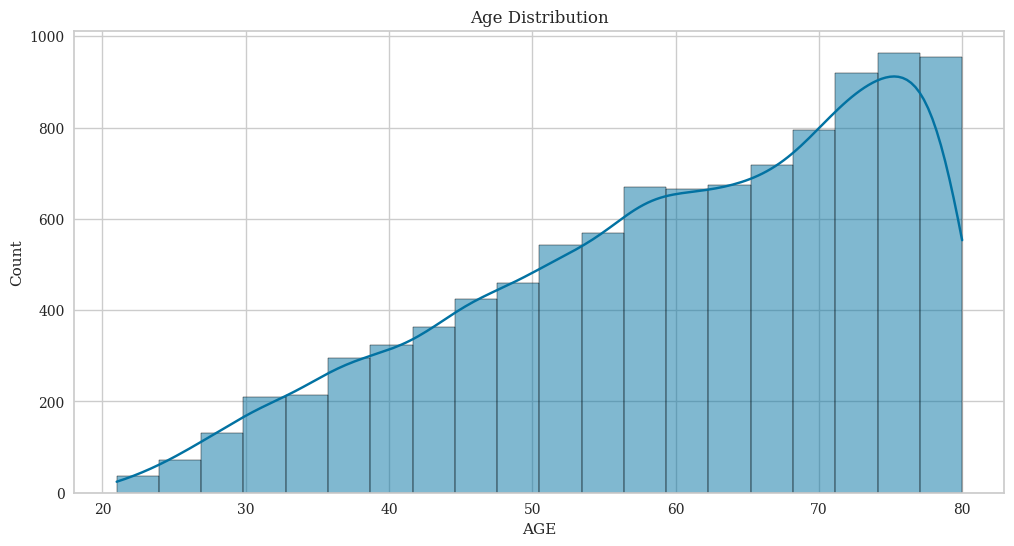

In [46]:
# Plotting distribution of age
plt.figure(figsize=(12, 6))
sns.histplot(customer_df['AGE'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

In [47]:
# Checking for missing values
print(customer_df.isna().sum())

PLAYER_ID                                  0
AGE                                        0
GENDER                                     0
HOME_COUNTRY                               0
HOME_CITY                                  0
DATE_FIRST_VISIT                           0
DATE_LAST_VISIT                            0
TOTAL_NUMBER_OF_VISITS                     0
TOTAL_DURATION_SPENT                       0
AVERAGE_DURATION_PER_VISIT                 0
TOTAL_CHIPS_WON_OR_LOST                    0
AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT        0
UNIQUE_GAMES_PLAYED                        0
IS_PREMIUM_PLAYER                          0
IS_LOYALTY_CARD_HOLDER                     0
TOTAL_AMOUNT_SPENT_IN_HOTEL                0
TOTAL_DAYS_SPENT_HOTEL                     0
TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT    0
NUMBER_OF_RESTAURANT_VISITS                0
TOTAL_AMOUNT_SPENT_IN_SPA                  0
NUMBER_OF_SPA_VISITS                       0
TOTAL_REVENUE_TO_CASINO                    0
NUMBER_OF_

In [17]:
# Fill missing values or drop them if appropriate
customer_df = customer_df.dropna()  # Here we simply drop missing values

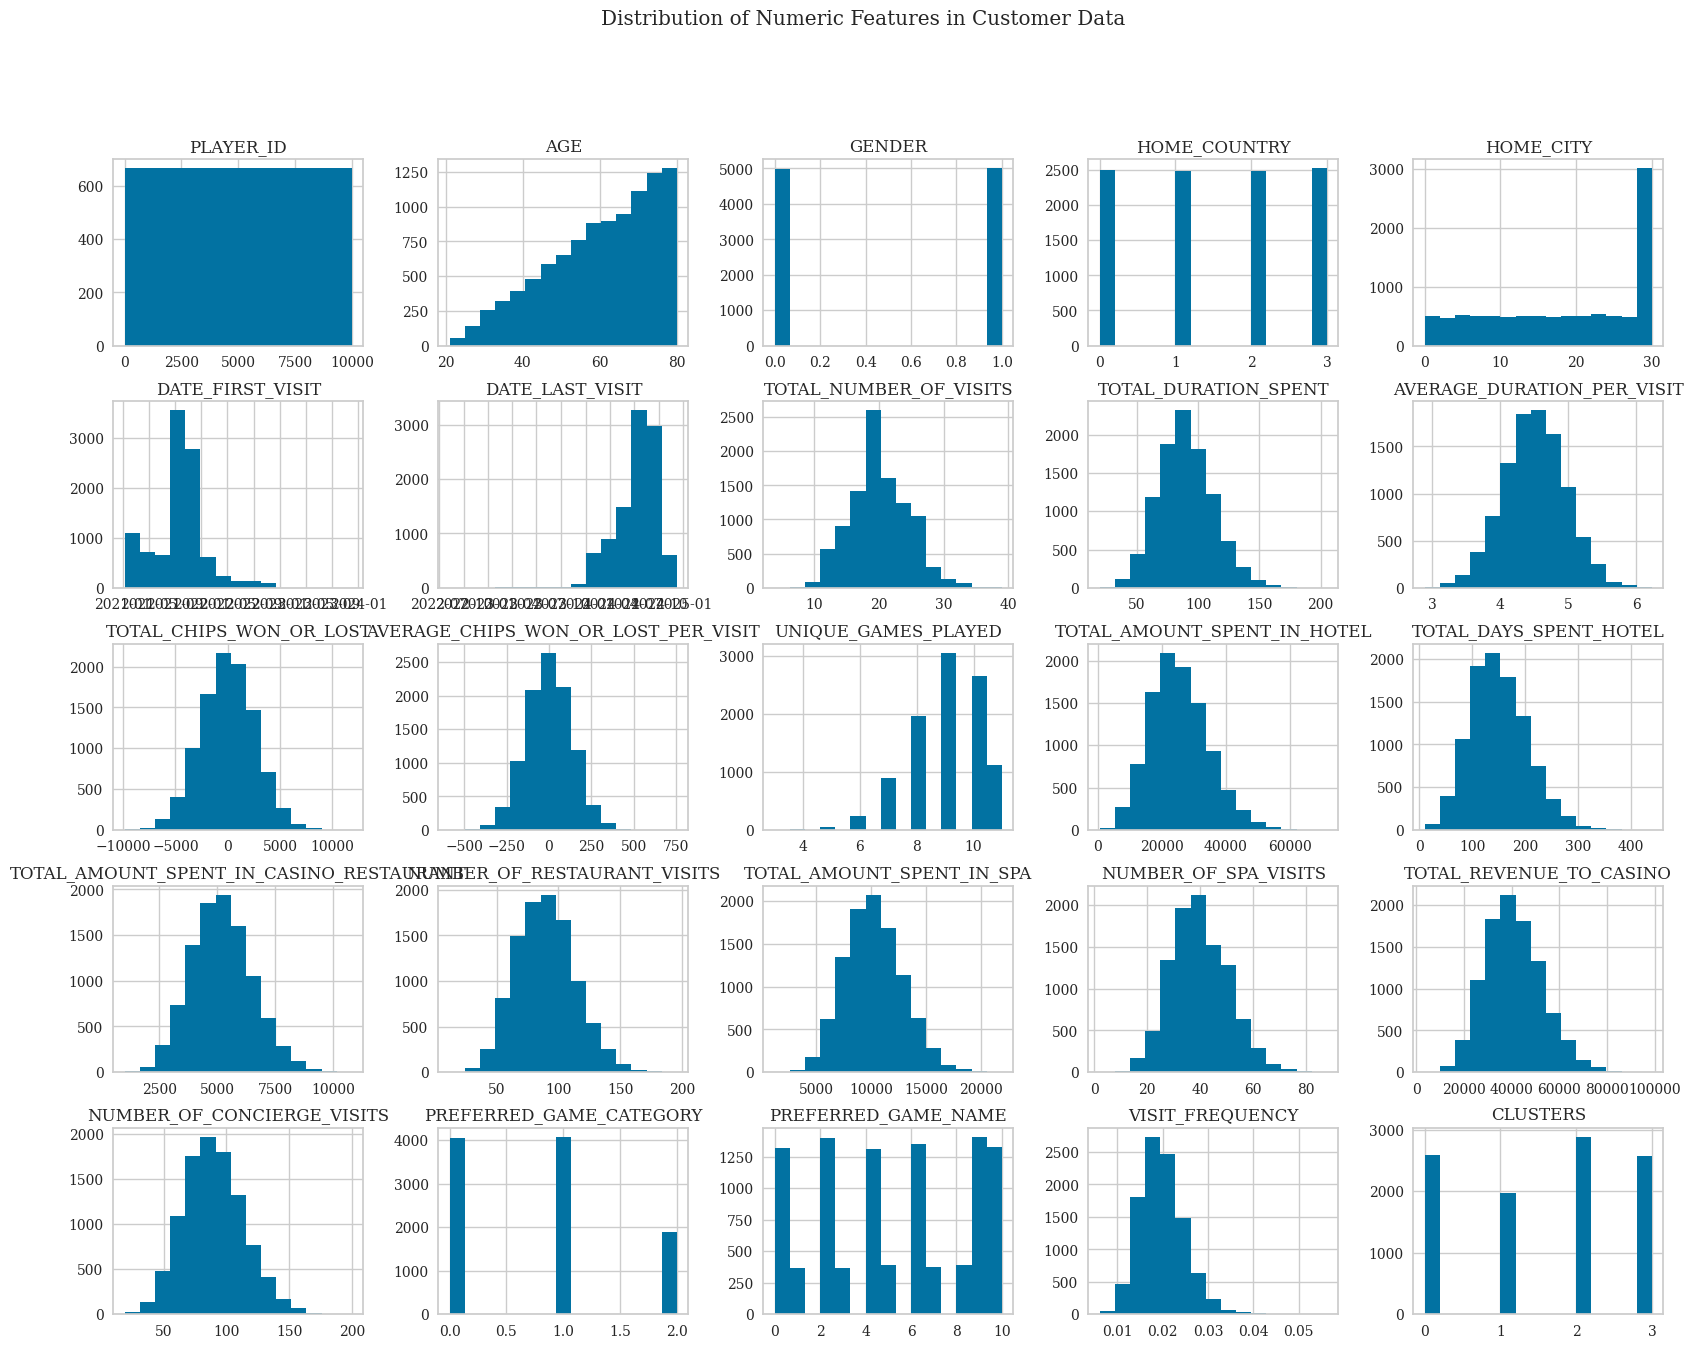

In [48]:
# Plotting distribution for numeric features in customer data
customer_df.hist(bins=15, figsize=(20, 15))
plt.suptitle('Distribution of Numeric Features in Customer Data')
plt.show()

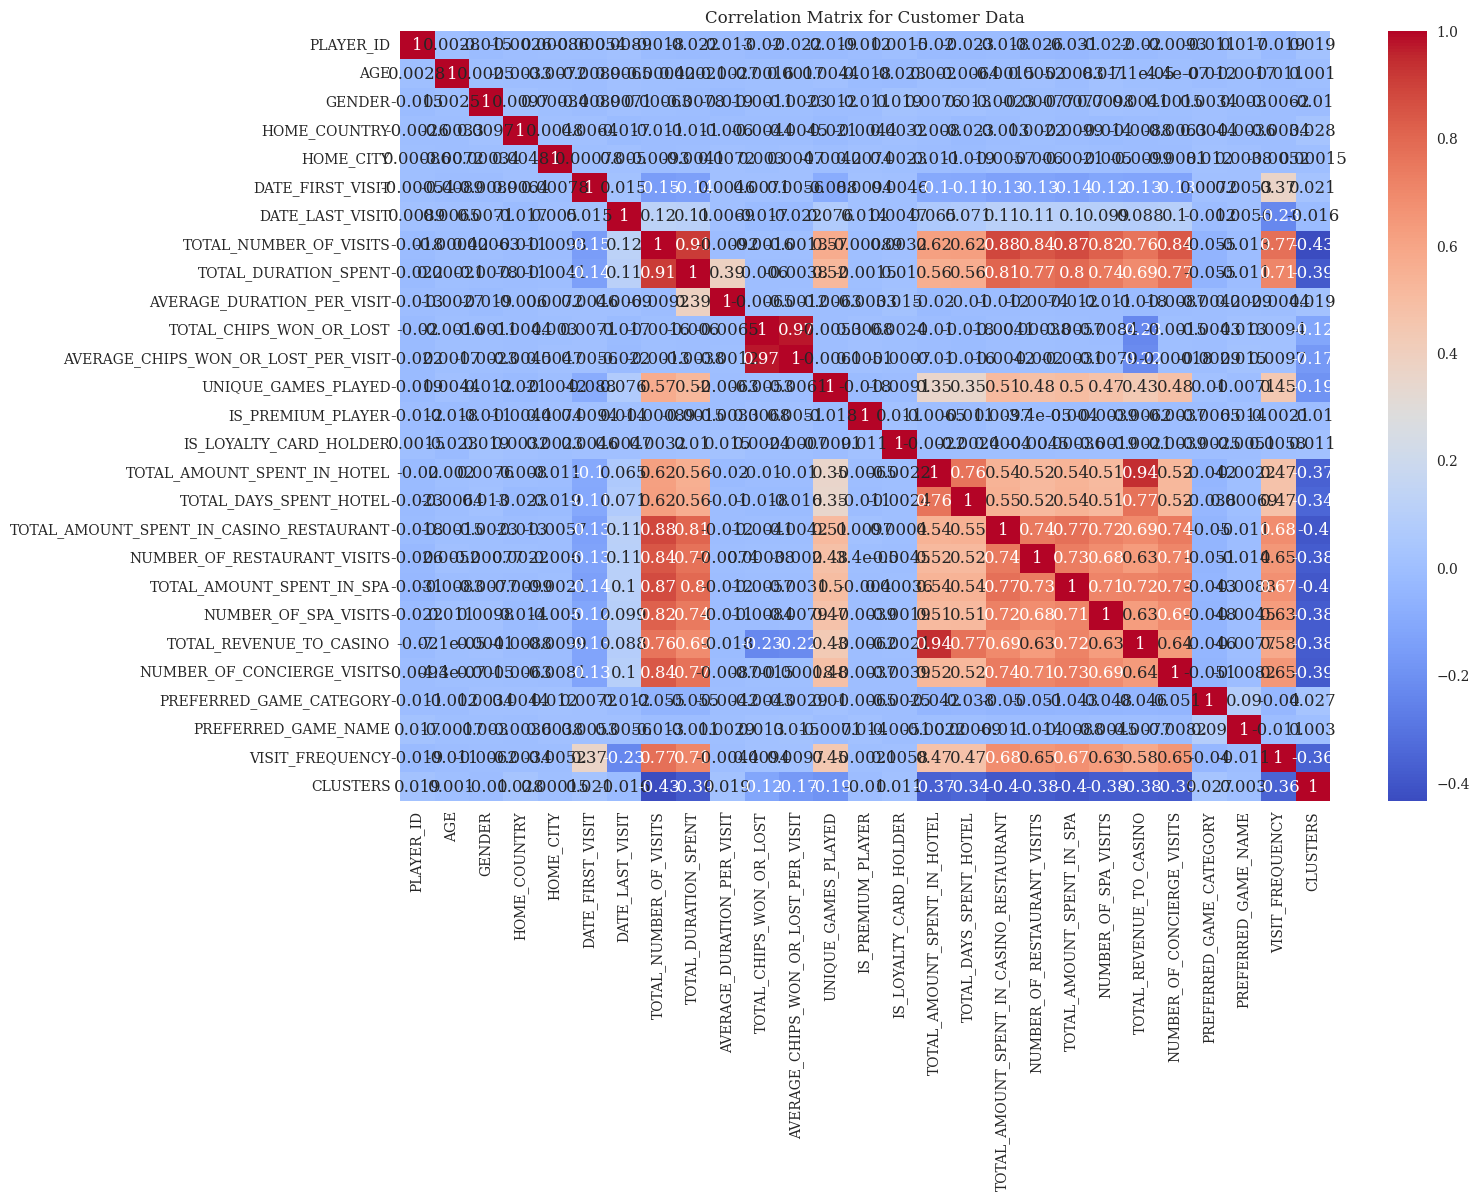

In [49]:
# Correlation matrix for customer_df
correlation_matrix = customer_df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Customer Data')
plt.show()

<Axes: >

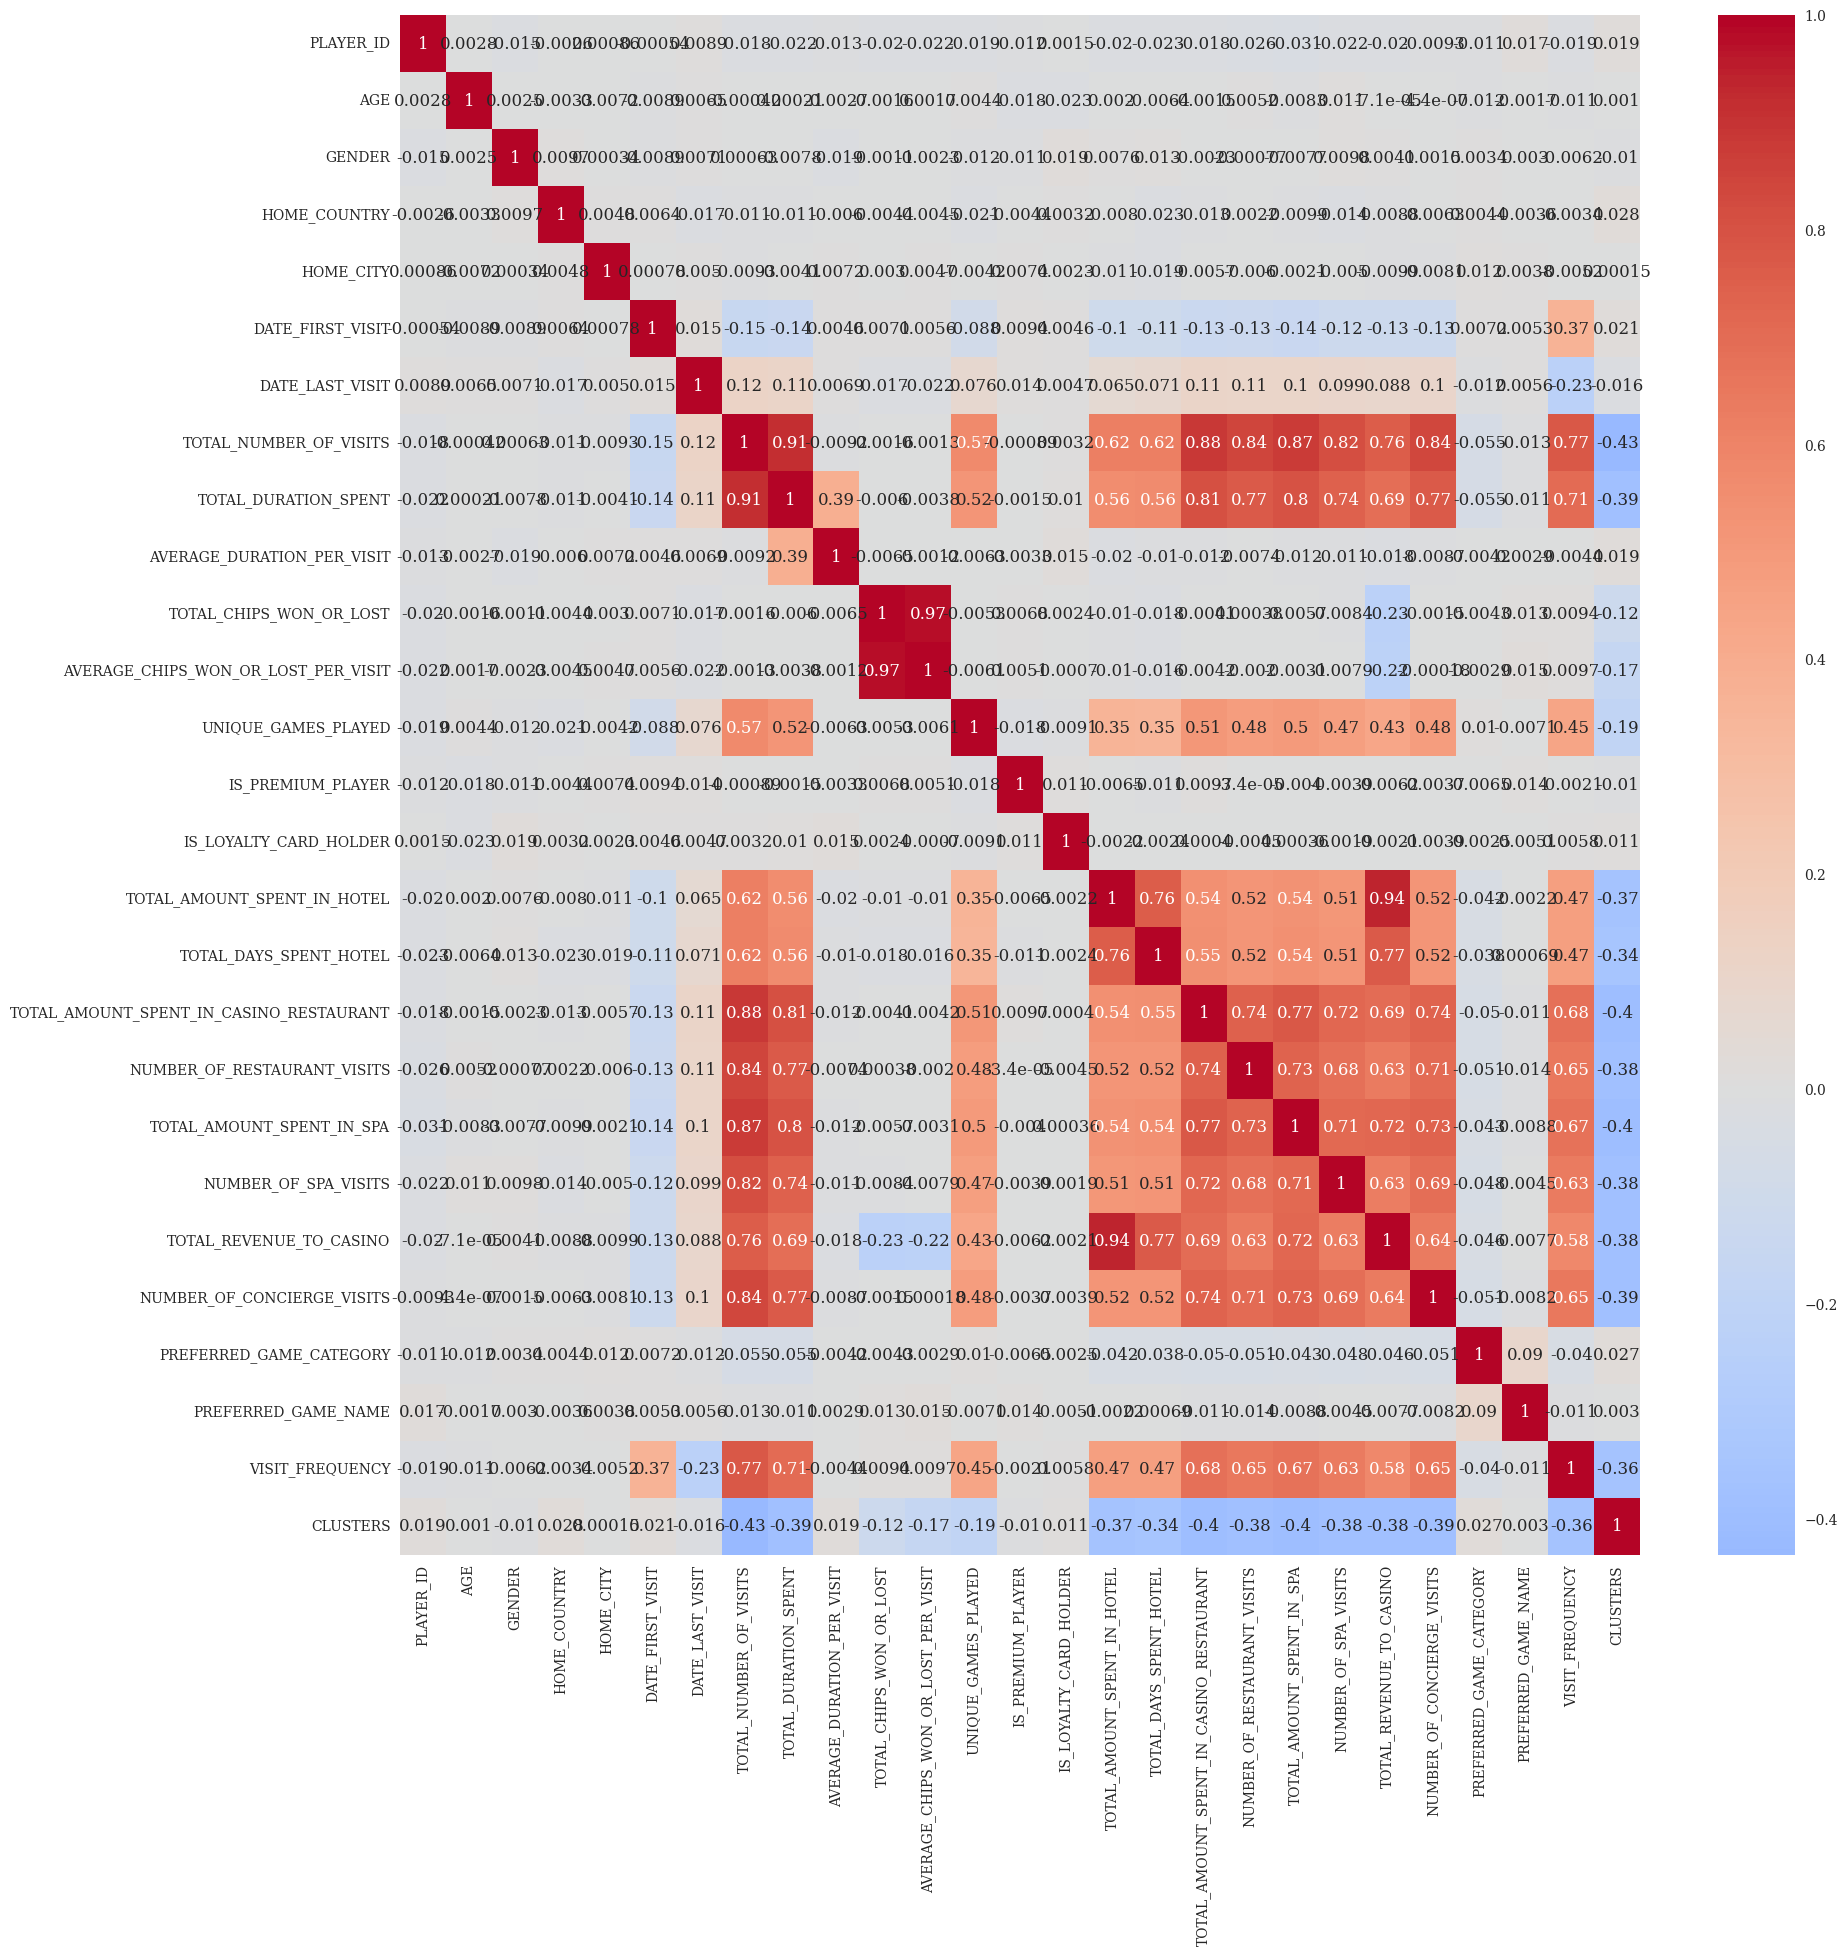

In [50]:
corrmat= customer_df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap='coolwarm', center=0)

In [63]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   PLAYER_ID                                10000 non-null  int16         
 1   AGE                                      10000 non-null  int8          
 2   GENDER                                   10000 non-null  int64         
 3   HOME_COUNTRY                             10000 non-null  int64         
 4   HOME_CITY                                10000 non-null  int64         
 5   DATE_FIRST_VISIT                         10000 non-null  datetime64[ns]
 6   DATE_LAST_VISIT                          10000 non-null  datetime64[ns]
 7   TOTAL_NUMBER_OF_VISITS                   10000 non-null  int8          
 8   TOTAL_DURATION_SPENT                     10000 non-null  float64       
 9   AVERAGE_DURATION_PER_VISIT              

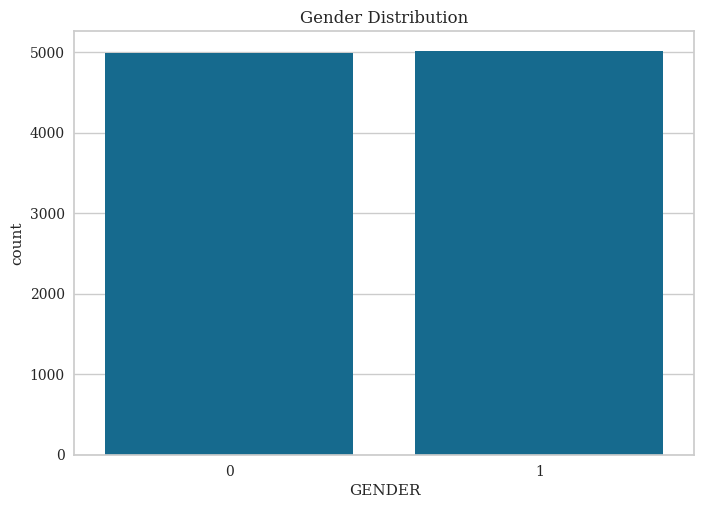

In [51]:
# Plotting categorical features against target variable
sns.countplot(x='GENDER', data=customer_df)
plt.title('Gender Distribution')
plt.show()

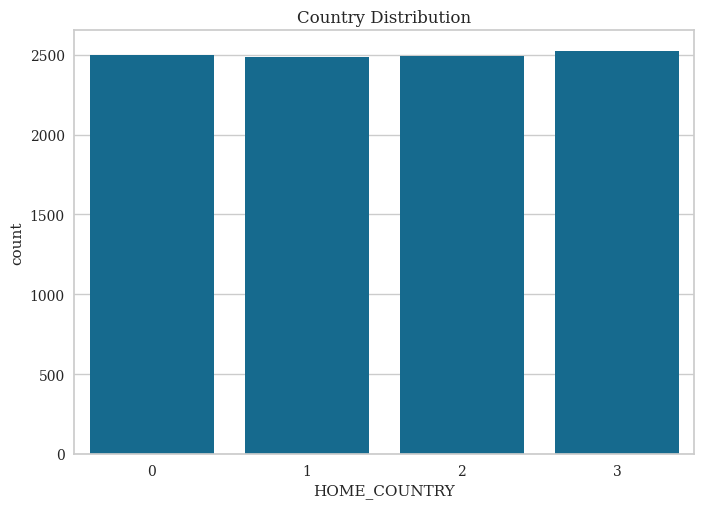

In [53]:
sns.countplot(x='HOME_COUNTRY', data=customer_df)
plt.title('Country Distribution')
plt.show()

## PCA: Principal component analysis

In [26]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,10000.0,-3.979039e-17,2.863293,-9.987234,-1.997354,-0.129645,1.900333,12.075122
col2,10000.0,4.263256e-17,1.425189,-5.360350,-0.973715,-0.003820,0.966713,5.625063
col3,10000.0,4.263256e-18,1.093733,-3.942877,-0.746177,-0.010026,0.735637,4.069541


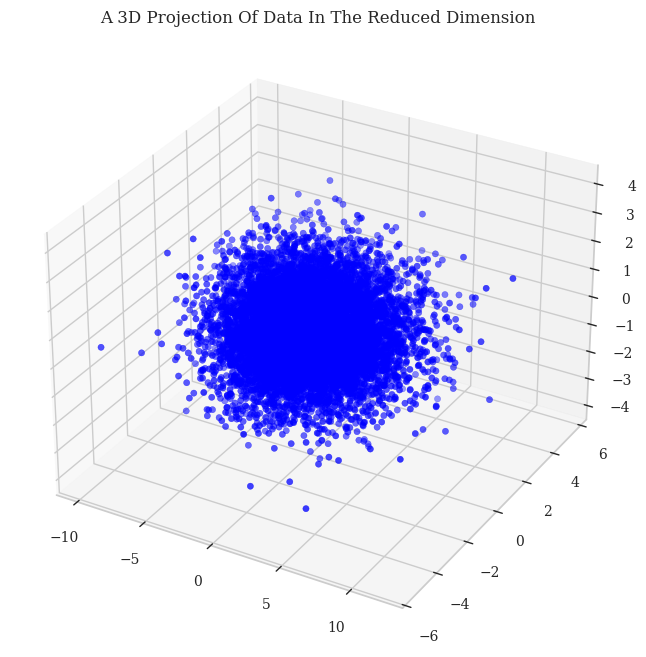

In [54]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="blue", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## Clustering
Steps involved in the Clustering

Elbow Method to determine the number of clusters to be formed
Clustering via Agglomerative Clustering
Examining the clusters formed via scatter plot

Elbow Method to determine the number of clusters to be formed:


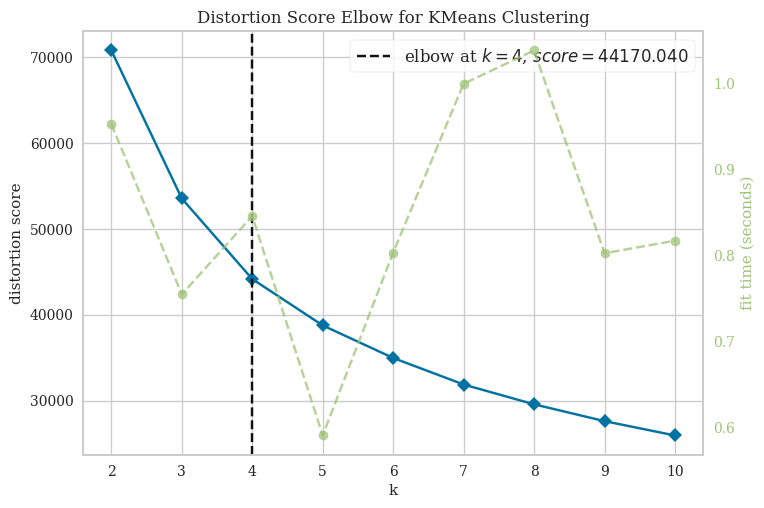

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

The above cell indicates that 5 will be an optimal number of clusters for this data. 
Next, we will be fitting the Agglomerative Clustering Model to get the final clusters.

In [57]:
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["CLUSTERS"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
customer_df["CLUSTERS"]= yhat_AC

ValueError: 'cmap' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

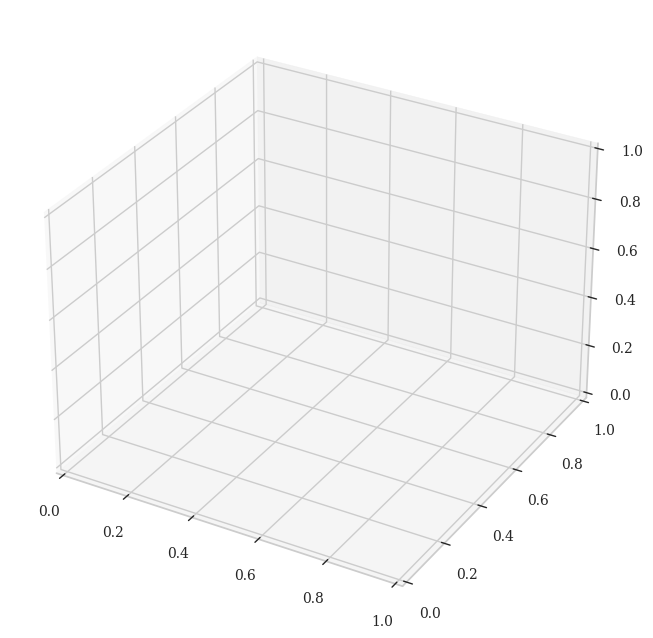

In [59]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="Check")
ax.scatter(x, y, s=40, c=PCA_ds["CLUSTERS"], marker='o', cmap = "cmap" )
ax.set_title("The Plot Of The Clusters")
plt.show()

## Model Evaluation

Since this is an unsupervised clustering. We do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will be having a look at the data in light of clusters via exploratory data analysis and drawing conclusions.

Firstly, let us have a look at the group distribution of clustring

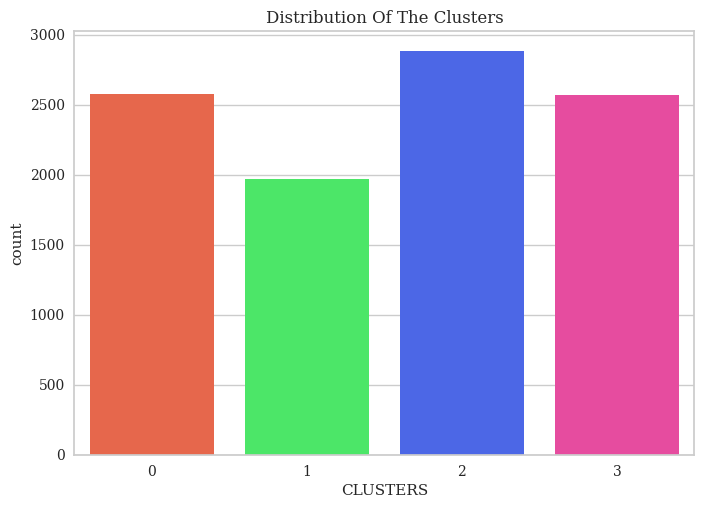

In [60]:
#Plotting countplot of clusters
pal = ["#FF5733","#33FF57", "#3357FF","#FF33A1",] #"#FFD700"]
pl = sns.countplot(x=customer_df["CLUSTERS"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

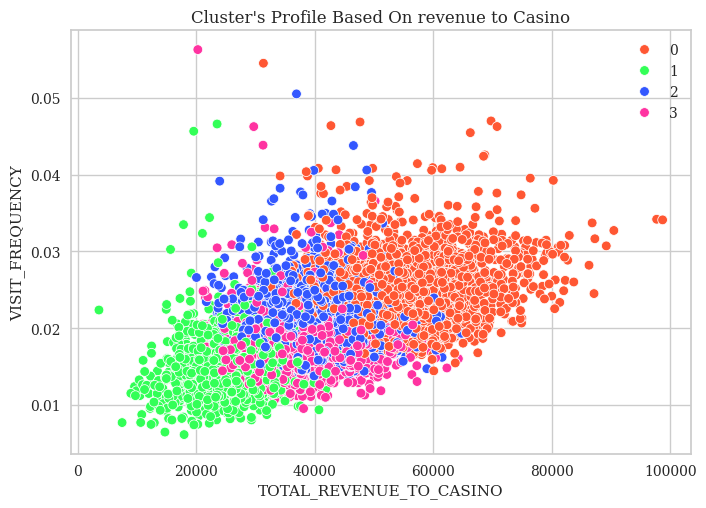

In [61]:
pl = sns.scatterplot(data = customer_df,x=customer_df["TOTAL_REVENUE_TO_CASINO"], y=customer_df["VISIT_FREQUENCY"],hue=customer_df["CLUSTERS"], palette= pal)
pl.set_title("Cluster's Profile Based On revenue to Casino")
plt.legend()
plt.show()

ANALYSE THE GROUP BEHAVIOR BY RECHECKING THE TRENDS
Income vs spending plot shows the clusters pattern

group 0: high spending & average income
group 1: high spending & high income
group 2: low spending & low income
group 3: high spending & low income
Next, I will be looking at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

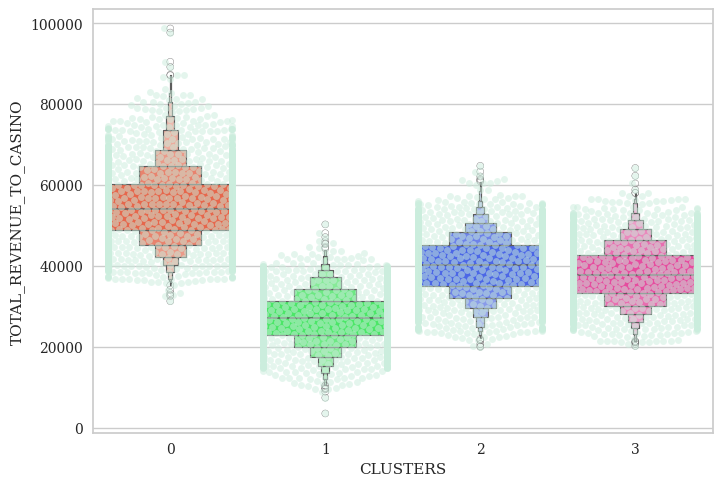

In [62]:
plt.figure()
pl=sns.swarmplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_REVENUE_TO_CASINO"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_REVENUE_TO_CASINO"], palette=pal)
plt.show()

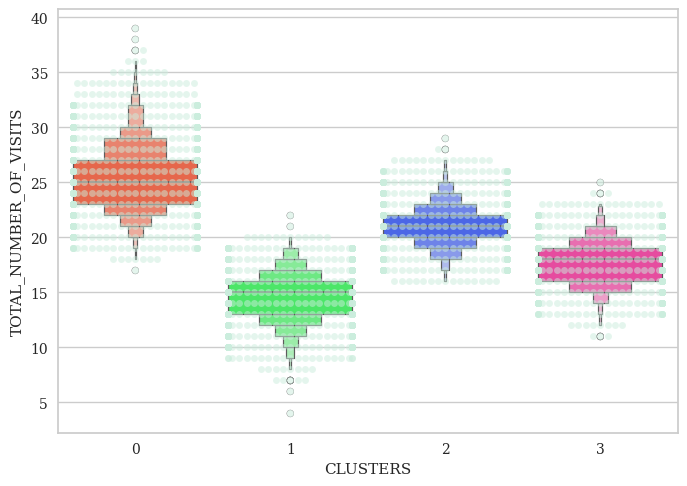

In [64]:
plt.figure()
pl=sns.swarmplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_NUMBER_OF_VISITS"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=customer_df["CLUSTERS"], y=customer_df["TOTAL_NUMBER_OF_VISITS"], palette=pal)
plt.show()

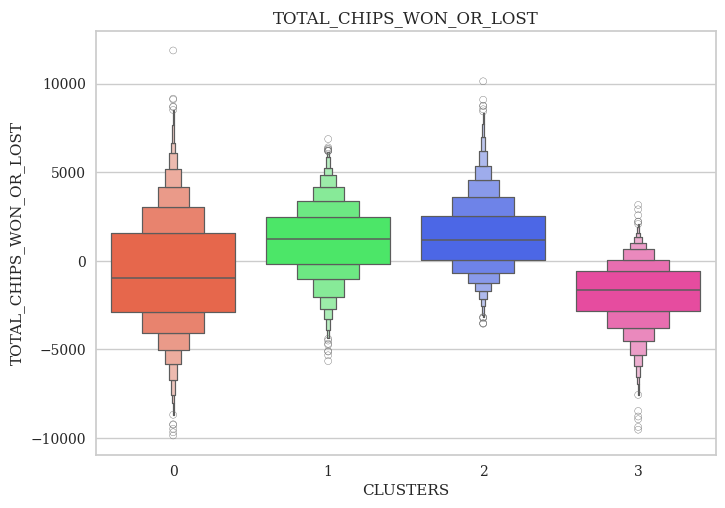

In [67]:
#Plotting
plt.figure()
pl=sns.boxenplot(y=customer_df["TOTAL_CHIPS_WON_OR_LOST"],x=customer_df["CLUSTERS"], palette= pal)
pl.set_title("TOTAL_CHIPS_WON_OR_LOST")
plt.show()

## PROFILING

Now that we have formed the clusters and looked at their purchasing habits. Let us see who all are there in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that I will be plotting some of the features that are indicative of the customer's personal traits in light of the cluster they are in. On the basis of the outcomes, I will be arriving at the conclusions.

<Figure size 800x550 with 0 Axes>

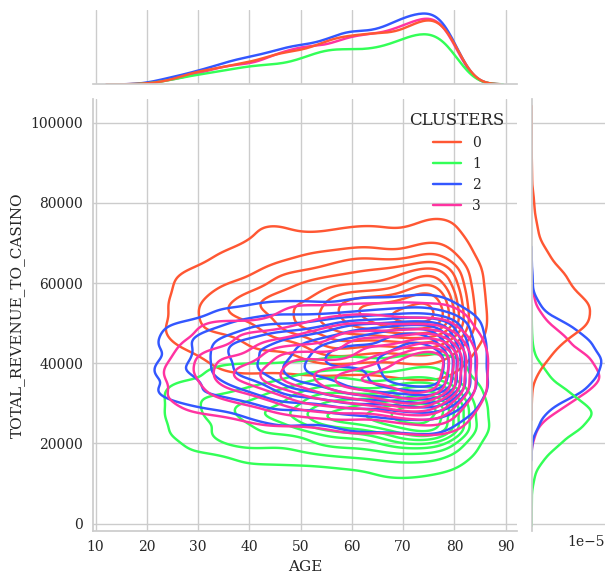

<Figure size 800x550 with 0 Axes>

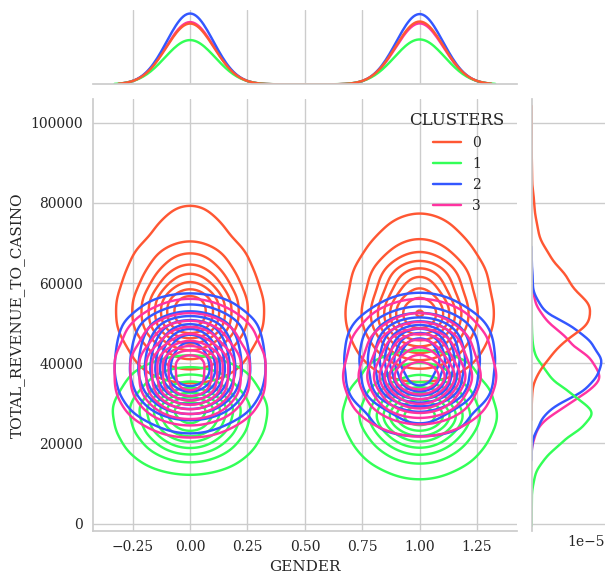

KeyError: ',HOME_COUNTRY'

<Figure size 800x550 with 0 Axes>

In [70]:
column_list = [ "AGE", "GENDER",",HOME_COUNTRY","TOTAL_DURATION_SPENT","TOTAL_CHIPS_WON_OR_LOST","AVERAGE_DURATION_PER_VISIT",
               "AVERAGE_CHIPS_WON_OR_LOST_PER_VISIT", "UNIQUE_GAMES_PLAYED", 
               "IS_PREMIUM_PLAYER", "IS_LOYALTY_CARD_HOLDER", "TOTAL_AMOUNT_SPENT_IN_HOTEL", "TOTAL_DAYS_SPENT_HOTEL",
               "TOTAL_AMOUNT_SPENT_IN_CASINO_RESTAURANT","NUMBER_OF_RESTAURANT_VISITS", "TOTAL_AMOUNT_SPENT_IN_SPA", "NUMBER_OF_SPA_VISITS",
               "TOTAL_REVENUE_TO_CASINO", "NUMBER_OF_CONCIERGE_VISITS", "VISIT_FREQUENCY"]

for i in column_list:
    plt.figure()
    sns.jointplot(x=customer_df[i], y=customer_df["TOTAL_REVENUE_TO_CASINO"], hue =customer_df["CLUSTERS"], kind="kde", palette=pal)
    plt.show()